# Softmax Tutorial

First we import the needed libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse

Next we import the MNIST data files we are going to be classifying. This database contains images of thousands of handwritten digits, and their proper labels. For convenience I am using a script from Google, which can be download [here](https://github.com/tensorflow/tensorflow/blob/r0.7/tensorflow/examples/tutorials/mnist/input_data.py). Just add it to your working directory, and it will download the MNIST database for you. We are going to use 500 training examples, and 100 test examples.

In [2]:
def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    #Taken from: 'https://mattpetersen.github.io/load-mnist-with-numpy'
    import gzip
    import os
    from urllib.request import urlretrieve

    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist("datasets/MNIST")

Let's take a look at one of the images in the set. Looks like a 4!

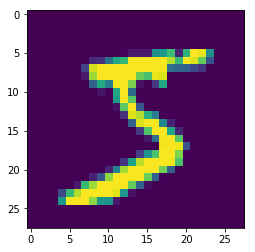

In [4]:
example = train_images[0] #Then we load that example.
plt.imshow(np.reshape(example,[28,28])) #Next we reshape it to 28x28 and display it.

Now we set the loaded data as our x and y variables for both the train and test sets.

### Before we can get to training our model using the data, we will have to define a few functions that the training and testing process can use.

Here we define the loss function for softmax regression.

In [5]:
def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    #y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities
    loss = (-1 / m) * np.sum(y * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T,(y - prob)) + lam*w #And compute the gradient for that loss
    return loss,grad

The below function converts integer class coding, where there is a unidimensional array of labels into a one-hot varient, where the array is size m (examples) x n (classes).

In [6]:
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

Here we perform the softmax transformation:
This allows us to get probabilities for each class score that sum to 100%.


<img src="https://upload.wikimedia.org/math/0/9/9/0991837b7d5a522ebc156f51dadbed0e.png">

In [7]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

Here we determine the probabilities and predictions for each class when given a set of input data:

In [8]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

### This is the main loop of the softmax regression. 
Here we initialize our weights, regularization factor, number of iterations, and learning rate. We then loop over a computation of the loss and gradient, and application of gradient.

In [9]:
w = np.zeros([train_images.shape[1], train_labels.shape[1]])
losses = []

In [31]:
%%time
lam = 0.0
iterations = 500
learningRate = 0.001
for i in range(0,iterations):
    index = np.random.randint(0,6000, size=3000)
    loss,grad = getLoss(w,train_images[index],train_labels[index],lam)
    #print(loss)
    losses.append(loss)
    w = w - (learningRate * grad)

CPU times: user 21.7 s, sys: 376 ms, total: 22.1 s
Wall time: 11.1 s


We can look at how the loss (hopefully) decreases over time.

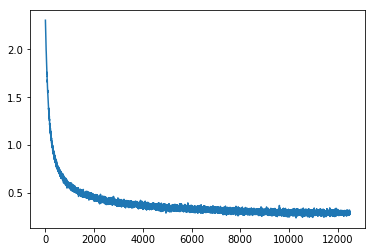

In [32]:
plt.plot(losses)

### Now that we have trained our model, we can see how well it is able to perform on both the training and test sets:

In [33]:
def getAccuracy(someX,someY):
    prob,prede = getProbsAndPreds(someX)
    boolarr = prede == someY.argmax(axis=1)
    return np.sum(boolarr) / boolarr.size  

In [34]:
print('Training Accuracy: ', getAccuracy(train_images,train_labels))
print('Test Accuracy: ', getAccuracy(test_images,test_labels))

Training Accuracy:  0.8950666666666667
Test Accuracy:  0.9006


### One of the benefits of a simple model like softmax is that we can visualize the weights for each of the classes, and see what it prefers. Here we look at the weights for the '3' class.

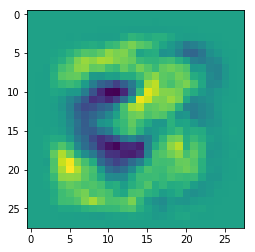

In [50]:
classWeightsToVisualize = 3
plt.imshow(scipy.reshape(w[:,classWeightsToVisualize],[28,28]))